<a href="https://colab.research.google.com/github/sultanmurat97/cancer_detection/blob/main/Cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

## Install dependencies and Import 

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 399.1MB 37kB/s 
     |████████████████████████████████| 4.0MB 57.7MB/s 
     |████████████████████████████████| 12.2MB 40.3MB/s 
     |████████████████████████████████| 471kB 52.2MB/s 
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from random import random
from random import seed
from tensorflow.keras import layers
import PIL
import shutil

from google.colab import drive

patch_size = [299, 299]

magnification_level = 2

percent_threshold = 30

train_slides = [101]
validation_slides = [94]
test_slides = [84]

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def percent_tissue(tissue_pixels, slide_image):
  return len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100

## Download model and train, validation files

In [ ]:
train_file = "train.zip"
train_folder =  'train/'

In [ ]:
!unzip -q $train_file -d $train_folder

In [ ]:
validation_file = "validation.zip"
validation_folder =  'validation/'
!unzip -q $validation_file -d $validation_folder

In [ ]:
finetuned_file = "finetuned.zip"
finetuned_folder =  'finetuned/'
!unzip -q $finetuned_file -d $finetuned_folder

In [ ]:
loaded = keras.models.load_model("finetuned")
model = loaded

In [ ]:
loaded.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_root = 'drive/MyDrive/'

In [ ]:
slides_folder = os.path.join(drive_root, 'slides/')
print(slides_folder)

drive/MyDrive/slides/


# Download all slides and create folders

In [ ]:
train_dir = "train"
validation_dir = "validation"

normal_validation_dir = 'validation/normal'
cancer_validation_dir = 'validation/cancer'
normal_train_dir = 'train/normal'
cancer_train_dir = 'train/cancer'



In [ ]:
test_dir = "test"

normal_test_dir = 'test/normal'
cancer_test_dir = 'test/cancer'

In [ ]:
if os.path.exists(test_dir) == False:
  os.mkdir(test_dir)

if os.path.exists(normal_test_dir) == False:
  os.mkdir(normal_test_dir)

if os.path.exists(cancer_test_dir) == False:
  os.mkdir(cancer_test_dir) 

In [ ]:
if os.path.exists(train_dir) == False:
  os.mkdir(train_dir)

if os.path.exists(normal_train_dir) == False:
  os.mkdir(normal_train_dir)

if os.path.exists(cancer_train_dir) == False:
  os.mkdir(cancer_train_dir)

if os.path.exists(validation_dir) == False:
  os.mkdir(validation_dir)

if os.path.exists(normal_validation_dir) == False:
  os.mkdir(normal_validation_dir)

if os.path.exists(cancer_validation_dir) == False:
  os.mkdir(cancer_validation_dir)

In [ ]:
#downloading train slides from urls
import urllib.request

for i in train_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  slide_path = 'tumor_' + i + '.tif' # only this file is available
  tumor_mask_path = 'tumor_' + i + '_mask.tif' # only this file is available

  slide_drive_path = 'drive/MyDrive/slides/' + slide_path
  mask_drive_path = 'drive/MyDrive/slides/' + tumor_mask_path
 
  if os.path.exists(slide_path) == False:
    !cp $slide_drive_path $slide_path

  if os.path.exists(tumor_mask_path) == False:
    !cp $mask_drive_path $tumor_mask_path

In [ ]:
#copy validation slides from drive
import urllib.request

for i in validation_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  
  slide_path = 'tumor_' + i + '.tif' # only this file is available
  tumor_mask_path = 'tumor_' + i + '_mask.tif' # only this file is available

  slide_drive_path = 'drive/MyDrive/slides/' + slide_path
  mask_drive_path = 'drive/MyDrive/slides/' + tumor_mask_path
 
  if os.path.exists(slide_path) == False:
    !cp $slide_drive_path $slide_path

  if os.path.exists(tumor_mask_path) == False:
    !cp $mask_drive_path $tumor_mask_path

In [ ]:
#copy test slides from drive
import urllib.request

for i in test_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  
  slide_path = 'tumor_' + i + '.tif' # only this file is available
  tumor_mask_path = 'tumor_' + i + '_mask.tif' # only this file is available

  slide_drive_path = 'drive/MyDrive/slides/' + slide_path
  mask_drive_path = 'drive/MyDrive/slides/' + tumor_mask_path
 
  if os.path.exists(slide_path) == False:
    !cp $slide_drive_path $slide_path

  if os.path.exists(tumor_mask_path) == False:
    !cp $mask_drive_path $tumor_mask_path

# One magnification level

## Extract patches and labels from slide images

In [ ]:
def sliding_window2(slide, mask, stepSize, windowSize, name):
  print('Sliding over image ' + name)
  shape_of_image = slide.level_dimensions[magnification_level]
  count = 0
  overall_count = 0
  print(shape_of_image)
  #print('heeye')
  for x in range(160, shape_of_image[0]-160, stepSize):
    for y in range(160, shape_of_image[1]-160, stepSize):
      
      current_image = read_slide(slide,
                                 x=int((x-149.5)*slide.level_downsamples[magnification_level]),
                                 y=int((y-149.5)*slide.level_downsamples[magnification_level]),
                                 level=magnification_level,
                                 width=299,
                                 height=299 )
      
      #print("First coordinate: ", int(y-149.5)*slide.level_downsamples[magnification_level])
      #print("Second coordinate: ", int(x-149.5)*slide.level_downsamples[magnification_level])
      current_mask = read_slide(mask,
                                 x=int((x-149.5)*slide.level_downsamples[magnification_level]),
                                 y=int((y-149.5)*slide.level_downsamples[magnification_level]),
                                 level=magnification_level,
                                 width=299,
                                 height=299)

      current_mask = current_mask[:,:,0]
      #print(current_mask.shape)
      overall_count += 1
      if current_mask.shape != (299,299):
        continue
      #print('Shape of current image: ', current_image.shape)
      
      start = int((current_mask.shape[0]-128)/2)
      end = int((current_mask.shape[0]-128)/2) + 128
      
      tissue_pixels = find_tissue_pixels(current_image)
      percent = percent_tissue(tissue_pixels, current_image)    
      tissue_regions = apply_mask(current_image, tissue_pixels)
      current_image= tissue_regions
      #plt.imshow(current_image)
      #print('Shape of current_image: ', current_image.shape)
      #print('Shape of current mask: ', current_mask.shape)
      #print('Percent: ', percent)
      if percent > percent_threshold:
        count = count + 1
        #print('Percentage: ', percent)
        cancerous = False
        for i in range(start, end):
          for j in range(start,end):
            if current_mask[i][j] != 0:
              cancerous = True
              break

        current_image = Image.fromarray(current_image)

        if cancerous == False:
          if int(name) in train_slides:
            if os.path.exists('train/normal/'+name +'-' +str(count)+'.png') == False:
              current_image.save('train/normal/'+name +'-' +str(count)+'.png')
          elif int(name) in validation_slides:
              if os.path.exists('validation/normal/'+name+'-'+str(count)+'.png') == False:
                current_image.save('validation/normal/'+name+'-'+str(count)+'.png')
          elif int(name) in test_slides:
              if os.path.exists('test/normal/'+name+'-'+str(count)+'.png') == False:
                current_image.save('test/normal/'+name+'-'+str(count)+'.png')
        else:
          if int(name) in train_slides:
              if os.path.exists('train/cancer/'+name +'-' +str(count)+'.png') == False:
                current_image.save('train/cancer/'+name +'-' +str(count)+'.png')
          elif int(name) in validation_slides:
              if os.path.exists('validation/cancer/'+name+'-'+str(count)+'.png') == False:
                current_image.save('validation/cancer/'+name+'-'+str(count)+'.png')
          elif int(name) in test_slides:
              if os.path.exists('test/cancer/'+name+'-'+str(count)+'.png') == False:
                current_image.save('test/cancer/'+name+'-'+str(count)+'.png')
        
      print(overall_count, count)
      
      #if overall_count == 4:
      #  break
    #if overall_count == 4:
    #  break
  #print('Overall count: ', overall_count)
  #print('Count: ', count)

In [ ]:
# extract patches for train set
for i in train_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  slide_path = 'tumor_' + i + '.tif' 
  tumor_mask_path = 'tumor_' + i + '_mask.tif'

  if os.path.exists(slide_path) == True:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    sliding_window2(slide,tumor_mask, 128, patch_size, i)

Read WSI from tumor_101.tif with width: 139264, height: 71680
Read tumor mask from tumor_101_mask.tif
Sliding over image 101
(34816, 17920)
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
16

KeyboardInterrupt: ignored

In [ ]:
# extract patches for validation set
for i in validation_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  slide_path = 'tumor_' + i + '.tif' 
  tumor_mask_path = 'tumor_' + i + '_mask.tif'

  if os.path.exists(slide_path) == True:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    sliding_window2(slide,tumor_mask, 128, patch_size, i)

Streaming output truncated to the last 5000 lines.
39621 11487
39622 11487
39623 11487
39624 11487
39625 11487
39626 11487
39627 11487
39628 11487
39629 11487
39630 11488
39631 11489
39632 11490
39633 11491
39634 11492
39635 11493
39636 11494
39637 11494
39638 11494
39639 11494
39640 11494
39641 11494
39642 11494
39643 11494
39644 11494
39645 11494
39646 11494
39647 11494
39648 11494
39649 11494
39650 11495
39651 11496
39652 11497
39653 11497
39654 11497
39655 11497
39656 11497
39657 11497
39658 11497
39659 11497
39660 11497
39661 11497
39662 11497
39663 11497
39664 11497
39665 11497
39666 11497
39667 11497
39668 11498
39669 11499
39670 11500
39671 11500
39672 11500
39673 11500
39674 11500
39675 11500
39676 11500
39677 11500
39678 11500
39679 11500
39680 11500
39681 11500
39682 11500
39683 11500
39684 11500
39685 11500
39686 11500
39687 11500
39688 11500
39689 11500
39690 11500
39691 11500
39692 11500
39693 11500
39694 11500
39695 11500
39696 11500
39697 11500
39698 11500
39699 11500
3

In [ ]:
# create zip for training and validation sets
shutil.make_archive('train', 'zip', '/content/train')

'/content/train.zip'

In [ ]:
shutil.make_archive('validation', 'zip', '/content/validation')

In [ ]:
shutil.make_archive('test', 'zip', '/content/test')

'/content/test.zip'

In [ ]:
# extract patches for test set
for i in test_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  slide_path = 'tumor_' + i + '.tif' 
  tumor_mask_path = 'tumor_' + i + '_mask.tif'

  if os.path.exists(slide_path) == True:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    sliding_window2(slide,tumor_mask, 128, patch_size, i)

Streaming output truncated to the last 5000 lines.
15917 5933
15918 5933
15919 5933
15920 5933
15921 5933
15922 5933
15923 5933
15924 5933
15925 5933
15926 5933
15927 5933
15928 5933
15929 5933
15930 5933
15931 5933
15932 5933
15933 5933
15934 5933
15935 5933
15936 5933
15937 5933
15938 5933
15939 5933
15940 5933
15941 5933
15942 5933
15943 5933
15944 5933
15945 5933
15946 5933
15947 5933
15948 5933
15949 5933
15950 5933
15951 5934
15952 5935
15953 5936
15954 5937
15955 5938
15956 5939
15957 5940
15958 5941
15959 5942
15960 5943
15961 5944
15962 5945
15963 5946
15964 5947
15965 5948
15966 5949
15967 5950
15968 5951
15969 5952
15970 5953
15971 5954
15972 5955
15973 5956
15974 5957
15975 5958
15976 5959
15977 5960
15978 5961
15979 5962
15980 5963
15981 5964
15982 5965
15983 5966
15984 5967
15985 5968
15986 5969
15987 5969
15988 5969
15989 5969
15990 5970
15991 5970
15992 5970
15993 5970
15994 5970
15995 5970
15996 5970
15997 5970
15998 5970
15999 5970
16000 5970
16001 5970
16002 5970
160

## Create Train, Validation and Test datasets


In [ ]:
train_dir = ('train')
validation_dir = ('validation')

BATCH_SIZE = 64
IMG_SIZE = (patch_size[0], patch_size[1])

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 8280 files belonging to 2 classes.


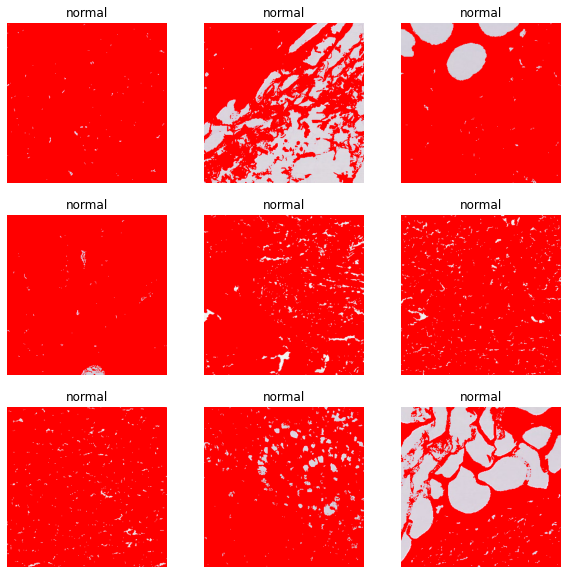

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print(class_names)

['cancer', 'normal']


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5905 files belonging to 2 classes.


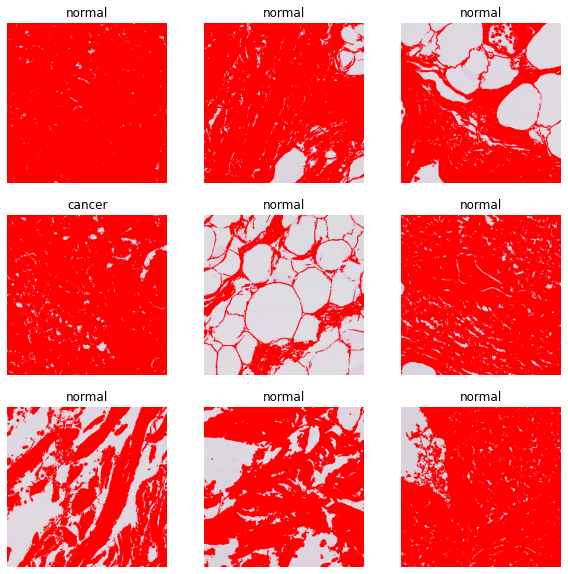

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
test_dir = ('test')

test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 6390 files belonging to 2 classes.


In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
#print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 130
Number of validation batches: 93


## Optimize input

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [ ]:
def color_perturbation_img(first_image):
  first_image = first_image[0]
  augmented_image = tf.image.random_brightness(first_image, 64/255)
  augmented_image = tf.image.random_saturation(augmented_image, 0, 0.25)
  augmented_image = tf.image.random_hue(augmented_image, 0.04)
  augmented_image = tf.image.random_contrast(augmented_image, 0, 0.75)
  return tf.expand_dims(augmented_image,0)

def color_perturbation():
  return layers.Lambda(lambda x: color_perturbation_img(x))

color_perturbation = color_perturbation()

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.5)
  #color_perturbation
])

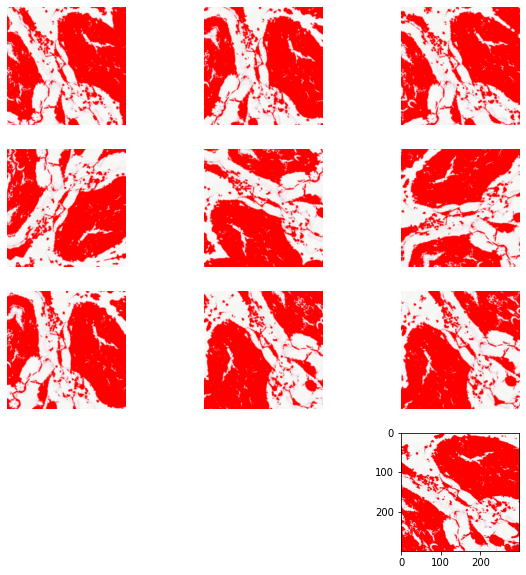

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  plt.subplot(4,3,12)
  plt.imshow(np.uint8(first_image))
  
  for i in range(9):
    ax = plt.subplot(4, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #print(augmented_image.shape)
    
    plt.imshow(np.uint8(augmented_image[0]))
    plt.axis('off')

## Transfer learning 

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 10, 10, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [ ]:
inputs = tf.keras.Input(shape=(patch_size[0], patch_size[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'),  keras.metrics.Recall(name='recall')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 2

loss0, accuracy0, auc0 = model.evaluate(validation_dataset)

#v1,v2 = model.evaluate(validation_dataset)

93/93 [==============================] - 175s 2s/step - loss: 0.8117 - accuracy: 0.3966 - auc: 0.7428 - precision: 0.9988 - recall: 0.3682


ValueError: ignored

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial auc: {:.2f}".format(auc0))


NameError: ignored

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/2
130/130 [==============================] - 496s 4s/step - loss: 0.4915 - accuracy: 0.7849 - auc: 0.5125 - precision: 0.8799 - recall: 0.8742 - val_loss: 0.2044 - val_accuracy: 0.9516 - val_auc: 0.8130 - val_precision: 0.9516 - val_recall: 1.0000
Epoch 2/2
130/130 [==============================] - 495s 4s/step - loss: 0.3745 - accuracy: 0.8777 - auc: 0.5859 - precision: 0.8779 - recall: 0.9996 - val_loss: 0.1813 - val_accuracy: 0.9516 - val_auc: 0.8810 - val_precision: 0.9516 - val_recall: 1.0000


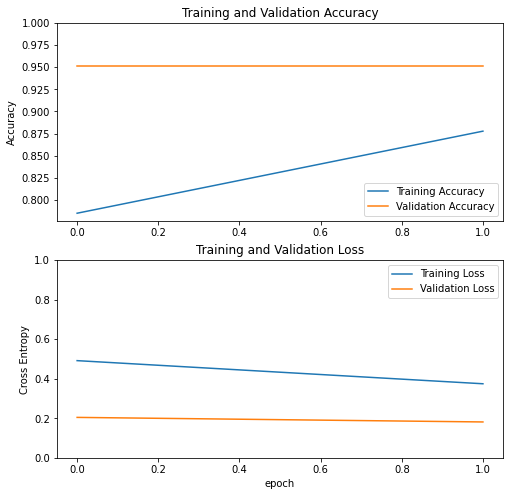

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and Prediction for Transfer Learning

In [ ]:
loss, accuracy, auc = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)
print('Loss:', loss)
print('AUC:', auc)

100/100 [==============================] - 213s 2s/step - loss: 0.2294 - accuracy: 0.9341 - auc: 0.7489
Test accuracy: 0.9341158270835876
Loss: 0.2294469177722931
AUC: 0.748897910118103


In [ ]:
count = 0
iter = test_dataset.as_numpy_iterator()
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
while count < 100:
  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()
  predictions = tf.where(predictions < 0.5, 0, 1)
  predictions = predictions.numpy()
  for i in range(len(label_batch)):
    if predictions[i] == 0 and label_batch[i] == 0:
      true_pos +=1
    if predictions[i] == 1 and label_batch[i] == 1:
      true_neg +=1
    if predictions[i] == 0 and label_batch[i] == 1:
      false_pos +=1
    if predictions[i] == 1 and label_batch[i] == 0:
      false_neg +=1 
  count = count + 1

In [ ]:
print('True pos:', true_pos)
print('True neg:', true_neg)
print('False pos:', false_pos)
print('False neg:', false_neg)
precision = true_pos/(true_pos+false_pos)
recall = true_pos/(true_pos+false_neg)
print('Precision:', precision)
print('Recall:', recall)
f1 = 2*recall*precision/(recall+precision)

True pos: 0
True neg: 6016
False pos: 185
False neg: 199
Precision: 0.0
Recall: 0.0


ZeroDivisionError: ignored

Predictions:
 [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
Labels:
 [1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]


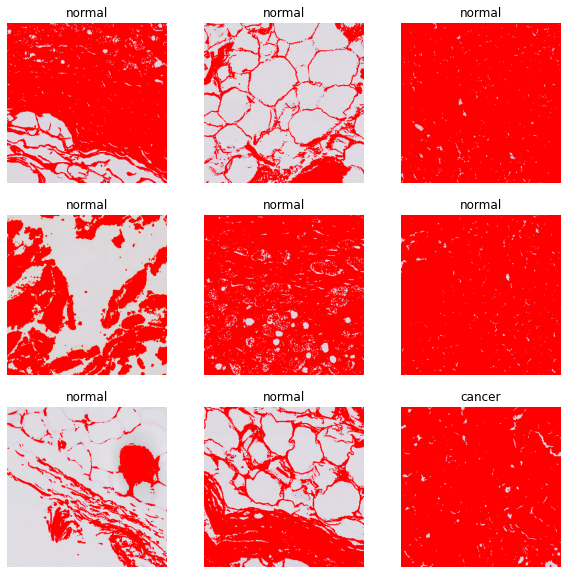

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.where(predictions < 0.93, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
temp = np.zeros((5,5))
print(temp)


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
temp[1:2, 2:5] = [255]

In [ ]:
print(temp)

[[  0.   0.   0.   0.   0.]
 [  0.   0. 255. 255. 255.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


In [ ]:
def create_mask(slide, stepSize, windowSize, name):

  print('Sliding over image ' + name)
  shape_of_image = slide.level_dimensions[magnification_level]
  count = 0
  print('Size is', shape_of_image)

  mask = np.zeros((shape_of_image[1], shape_of_image[0]))
  
  for y in range(160, shape_of_image[1]-160, stepSize):
    for x in range(160, shape_of_image[0]-160, stepSize):
      
      current_image = read_slide(slide,
                                 x=int((x-149.5)*slide.level_downsamples[magnification_level]),
                                 y=int((y-149.5)*slide.level_downsamples[magnification_level]),
                                 level=magnification_level,
                                 width=299,
                                 height=299 )
      

      tissue_pixels = find_tissue_pixels(current_image)
      percent = percent_tissue(tissue_pixels, current_image)    
      tissue_regions = apply_mask(current_image, tissue_pixels)
      current_image= tissue_regions
      
      res = ''
      if percent > percent_threshold:
        img_array = keras.preprocessing.image.img_to_array(current_image)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
      
        predictions = model.predict(img_array)
     
        #predictions = tf.where(predictions < 0.93, 0, 1)
        #predictions = predictions.numpy()
        #res = class_names[predictions[0][0]]
        #print(predictions[0][0])
        mask[(y-150):(y+149), (x-150):(x+149)] = [int((1-predictions[0][0])*255)]
      else:
        mask[(y-150):(y+149), (x-150):(x+149)] = [0]
      
      
        #print('normal')
        
      count = count + 1
      #print(count)
      #print(res)
      #if count == 100:
      #  break
    #if count == 100:
    #  break
  return mask


0.99847555


NameError: ignored

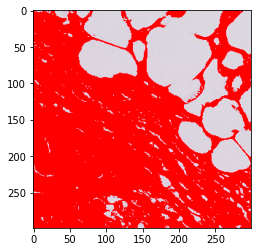

In [ ]:
# Imports PIL module  
from PIL import Image 

# open method used to open different extension image file 
im = Image.open('validation/cancer/094-10001.png')  
  
# This method will show image in any image viewer  
plt.imshow(im) 

img_array = keras.preprocessing.image.img_to_array(im)
#print(img_array)
#print(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch
      
      

#print('Shape of current image ', img_array.shape)
predictions = model.predict(img_array)
print(predictions[0][0])
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()
print(class_names[predictions[0][0]])

In [ ]:
slide_path_test = 'tumor_084.tif'
tumor_mask_path_test = 'tumor_084_mask.tif'
slide_test = open_slide(slide_path_test)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path_test, 
                                                        slide_test.level_dimensions[0][0], 
                                                        slide_test.level_dimensions[0][1]))

tumor_mask_test = open_slide(tumor_mask_path_test)
print ("Read tumor mask from %s" % (tumor_mask_path_test))



Read WSI from tumor_084.tif with width: 65536, height: 86016
Read tumor mask from tumor_084_mask.tif


In [ ]:
slide_image = read_slide(slide_test,
                         x=0,
                         y=0,
                         level = magnification_level,
                         width=slide_test.level_dimensions[magnification_level][0],
                         height=slide_test.level_dimensions[magnification_level][1])

In [ ]:
print(slide_test.level_dimensions[magnification_level])

(16384, 21504)


In [ ]:
slide_image.shape

(21504, 16384, 3)

In [ ]:
mask_image = read_slide(tumor_mask_test,
                         x=0,
                         y=0,
                         level = magnification_level,
                         width=tumor_mask_test.level_dimensions[magnification_level][0],
                         height=tumor_mask_test.level_dimensions[magnification_level][1])

In [ ]:
mask = create_mask(slide_test, 128, patch_size, '084')

Sliding over image 084
Size is (16384, 21504)


In [ ]:
mask.sum().sum()

783958016.0

In [ ]:
mask.shape

(21504, 16384)

In [ ]:
from PIL import Image
im = Image.fromarray(mask)

In [ ]:
im = im.convert('RGB')

In [ ]:
im.save("mask.jpeg")

In [ ]:
mask.sum().sum()

0.0

In [ ]:
print(slide_image.shape)
print(mask.shape)

(21504, 16384, 3)
(21504, 16384)


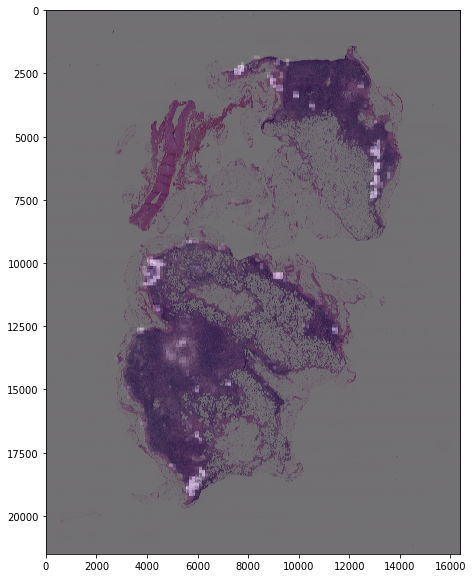

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(slide_image)
plt.imshow(im, cmap='jet', alpha=0.5)

In [ ]:
from numpy import save
save('mask.npy', mask)

In [ ]:
from numpy import load
from numpy import savez_compressed
savez_compressed('mask.npz', mask)

In [ ]:
dict_mask = load('mask.npz')

In [ ]:
mask = dict_mask['arr_0']

KeyboardInterrupt: ignored

## Fine tuning

### Un-freeze the top layers of the model 

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(name='precision'),  keras.metrics.Recall(name='recall')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 299, 299, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

158

### Continue training the model

In [ ]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 2/4
130/130 [==============================] - 1409s 11s/step - loss: 0.2850 - accuracy: 0.8850 - auc: 0.8321 - precision: 0.9029 - recall: 0.9738 - val_loss: 0.1044 - val_accuracy: 0.9566 - val_auc: 0.9548 - val_precision: 0.9567 - val_recall: 0.9996
Epoch 3/4
130/130 [==============================] - 1410s 11s/step - loss: 0.1891 - accuracy: 0.9312 - auc: 0.9240 - precision: 0.9416 - recall: 0.9827 - val_loss: 0.1036 - val_accuracy: 0.9592 - val_auc: 0.9471 - val_precision: 0.9619 - val_recall: 0.9966
Epoch 4/4
130/130 [==============================] - 1405s 11s/step - loss: 0.1661 - accuracy: 0.9414 - auc: 0.9387 - precision: 0.9504 - recall: 0.9847 - val_loss: 0.1329 - val_accuracy: 0.9539 - val_auc: 0.9188 - val_precision: 0.9541 - val_recall: 0.9996


In [ ]:
model.save('finetuned2')

INFO:tensorflow:Assets written to: finetuned2/assets


In [ ]:
# create zip for training and validation sets
import shutil
shutil.make_archive('train', 'zip', '/content/train')
shutil.make_archive('validation', 'zip', '/content/validation')

'/content/validation.zip'

In [ ]:
shutil.make_archive('finetuned2', 'zip', '/content/finetuned2')

'/content/finetuned2.zip'

## Evaluation and Prediction for Fine tuning

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


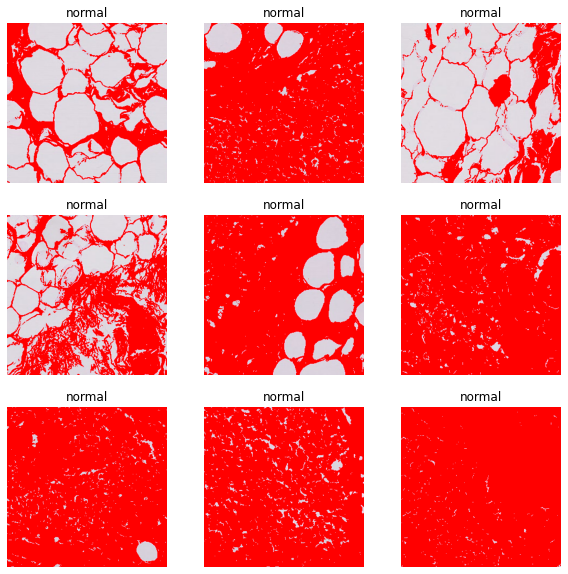

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

0.94756997
normal


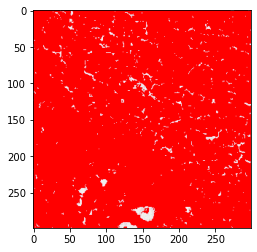

In [ ]:
# Imports PIL module  
from PIL import Image 

# open method used to open different extension image file 
im = Image.open('train/cancer/016-1018.png')  
  
# This method will show image in any image viewer  
plt.imshow(im) 

img_array = keras.preprocessing.image.img_to_array(im)
#print(img_array)
#print(img_array)
img_array = tf.expand_dims(img_array, 0) # Create a batch
      

#print('Shape of current image ', img_array.shape)
predictions = model.predict(img_array)
print(predictions[0][0])
predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()
print(class_names[predictions[0][0]])

In [ ]:
create_mask(slide_test, patch_size[0], patch_size, '091')

# Several magnification levels

## Extract patches from several magnification levels

In [ ]:
train_list = []

In [ ]:
def sliding_window_levels(slide4, slide5, tumor_mask, stepSize, windowSize, name):

  if os.path.exists('train2') == False:
    os.mkdir('train2')


  mask_image4 = mask_image4[:,:,0]
  mask_image5 = mask_image5[:,:,0]

  tissue_pixels5 = find_tissue_pixels(slide_image5)
  tissue_regions5 = apply_mask(slide_image5, tissue_pixels5)

  tissue_pixels4 = find_tissue_pixels(slide_image4)
  tissue_regions4 = apply_mask(slide_image4, tissue_pixels4)

  slide_image5 = tissue_regions5
  slide_image4 = tissue_regions4

  print('Sliding over image ' + name)
  #plt.figure(figsize=(10,10), dpi=100)
  count = 0
  for y in range(160, slide.level_dimensions[5][0]-160, stepSize):
    for x in range(160, slide.level_dimensions[5][1]-160, stepSize):
      #plt.subplot(6,7, count+1)
      current_image = slide_image5[y-150:y+149, x-150:x+149]
      current_mask = mask_image5[y-150:y+149, x-150:x+149]

      magnified_image = slide_image4[(2*y-150):(2*y+149), (2*x-150):(2*x+149)]
      magnified_mask = mask_image5[(2*y-150):(2*y+149), (2*x-150):(2*x+149)]
      cancerous = False
      start = int((current_mask.shape[0]-128)/2)
      end = int((current_mask.shape[0]-128)/2) + 128
      for i in range(start, end):
        for j in range(start,end):
          if current_mask[i][j] != 0:
            cancerous = True
            break
      current_image = Image.fromarray(current_image)
      magnified_image = Image.fromarray(magnified_image)
      if cancerous == False:
        value = random()
        if value < prob:
          if os.path.exists('train2/'+name +'-' +str(count)+'_5.jpg') == False:
            current_image.save('train2/'+name +'-' +str(count)+'_5.jpg')
          if os.path.exists('train2/'+name +'-' +str(count)+'_4.jpg') == False:
            magnified_image.save('train2/'+name +'-' +str(count)+'_4.jpg')
          train_list.append(['train2/'+name +'-' +str(count)+'_5.jpg', 'train2/'+name +'-' +str(count)+'_4.jpg', 0])
      else:
        if os.path.exists('train2/'+name +'-' +str(count)+'_5.jpg') == False:
          current_image.save('train2/'+name +'-' +str(count)+'_5.jpg')
        if os.path.exists('train2/'+name +'-' +str(count)+'_4.jpg') == False:
          magnified_image.save('train2/'+name +'-' +str(count)+'_4.jpg')
        train_list.append(['train2/'+name +'-' +str(count)+'_5.jpg', 'train2/'+name +'-' +str(count)+'_4.jpg', 1])
      #print('Shape of image: ', current_image.shape)
      #print('Shape of mask: ', current_mask.shape)
      #print()
      count = count + 1
      #plt.xticks([])
      #plt.yticks([])
      #plt.imshow(current_mask)
      #if count == 1:
      #  break
    #if count == 1:
    #  break
  print(count)

In [ ]:
for i in range_of_slides:
  if i < 10: 
    i = '00' + str(i)
  elif i < 100:
    i = '0' + str(i)
  elif i < 1000:
    i = str(i)

  slide_path = 'tumor_' + i + '.tif' # only this file is available
  tumor_mask_path = 'tumor_' + i + '_mask.tif' # only this file is available

  if os.path.exists(slide_path) == True:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    sliding_window_levels(slide,tumor_mask, 128, patch_size, i)

In [ ]:
print('Length of train_list: ',len(train_list))
for i in range(len(train_list)):
  if train_list[i][2] == 1:
    print(train_list[i])

In [ ]:
image5_train = []
image4_train = [] 
label_train = []
for i in range(len(train_list)):
  image5_train.append(train_list[i][0])
  image4_train.append(train_list[i][1])
  label_train.append(train_list[i][2])
print(image5_train)
print(image4_train)
print(label_train)



## Create dataset for training with multiple zoom levels

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
def load_np(img_path1, img_path2, label):
  img1 = tf.io.read_file(img_path1)
  img1 = tf.image.decode_jpeg(img1, channels=3)
  img1 = tf.image.resize(img1, (299, 299))

  img2 = tf.io.read_file(img_path2)
  img2 = tf.image.decode_jpeg(img2, channels=3)
  img2 = tf.image.resize(img2, (299, 299))
  return img1, img2, label, img_path1, img_path2

In [ ]:
# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of padded questions
# - a batch of numeric answers
# - a batch of absolute paths to the corresponding images
def create_dataset(images1, images2, labels2):
  dataset = tf.data.Dataset.from_tensor_slices((images1, 
                                                images2, 
                                                labels2))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to 
  # update on the website, so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.float32, tf.int32, tf.string, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_ds = create_dataset(image5_train, image4_train, label_train)

## Sanity check

In [ ]:
# Verify your datasets are working properly

# Here is code you can use to quickly retrieve a batch of data

my_iterator = iter(train_ds)
img1_batch, img2_batch, labels_batch, paths1_batch, paths2_batch = next(my_iterator)

print(img1_batch.shape,
      img2_batch.shape,
      labels_batch.shape,
      paths1_batch.shape,
      paths2_batch.shape)

print(img1_batch, img2_batch, labels_batch, paths1_batch, paths2_batch)

In [ ]:
# create the same lists for validation and test, sets

## Define model for several zoom levels

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model1 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model3 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
prediction_layer1 = tf.keras.layers.Dense(1, from_logits = True)
prediction_layer2 = tf.keras.layers.Dense(1, from_logits = True)
prediction_layer3 = tf.keras.layers.Dense(1, from_logits = True)

In [ ]:
inputs1 = tf.keras.Input(shape=(patch_size[0], patch_size[1], 3))
x1 = data_augmentation(inputs1)
x1 = preprocess_input(x1)
x1 = base_model1(x1, training=False)
x1 = global_average_layer(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
encoded_image1 = prediction_layer1(x1)

inputs2 = tf.keras.Input(shape=(patch_size[0], patch_size[1], 3))
x2 = data_augmentation(inputs2)
x2 = preprocess_input(x2)
x2 = base_model2(x2, training=False)
x2 = global_average_layer(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
encoded_image2 = prediction_layer2(x2)

inputs3 = tf.keras.Input(shape=(patch_size[0], patch_size[1], 3))
x3 = data_augmentation(inputs3)
x3 = preprocess_input(x3)
x3 = base_model3(x3, training=False)
x3 = global_average_layer(x3)
x3 = tf.keras.layers.Dropout(0.2)(x3)
encoded_image3 = prediction_layer3(x3)


# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_image1, encoded_image2])

# Optionally, add a small dense layer
dense = Dense(10, activation='relu')(merged)

# Next, add a binary classifier on top
output = Dense(1, activation='sigmoid')(dense)

# Your final model
combined_model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=output)

In [ ]:
combined_model.summary()

In [ ]:
combined_model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fit model on a single batch

In [ ]:
# Retrieve a batch of data from your train dataset
img1_batch, img2_batch, labels_batch = next(iter(train_ds))

In [ ]:
print(type(img1_batch))

In [ ]:
for i in range(90):
  metrics = combined_model.train_on_batch([img1_batch, img2_batch], labels_batch) 
  print(metrics[0], metrics[1])
# metrics is a list (loss is metrics[0], accuracy is metrics[1])

In [ ]:
combined_model.fit(x = [img1_batch, img2_batch], y = labels_batch, epochs = 10)